<a href="https://colab.research.google.com/github/Vothuw/Maze_Robot.cdhb/blob/main/mazerobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

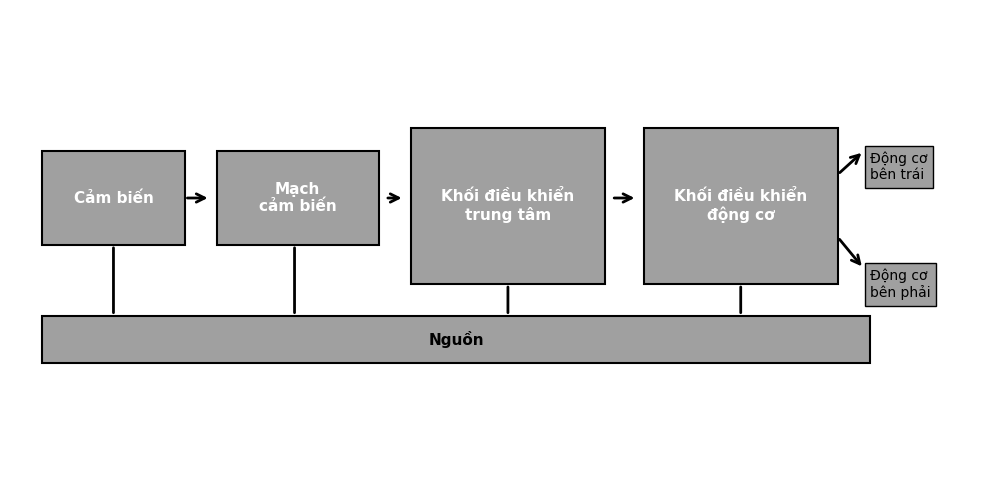

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

# Khởi tạo khung vẽ
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim(0, 15)
ax.set_ylim(0, 6)
ax.axis('off')

# ======= Vẽ các khối chính =======
blocks = [
    (0.5, 3, 2.2, 1.2, "Cảm biến"),
    (3.2, 3, 2.5, 1.2, "Mạch\ncảm biến"),
    (6.2, 2.5, 3.0, 2.0, "Khối điều khiển\ntrung tâm"),
    (9.8, 2.5, 3.0, 2.0, "Khối điều khiển\nđộng cơ"),
]

for (x, y, w, h, text) in blocks:
    rect = Rectangle((x, y), w, h, fc='#A0A0A0', ec='black', lw=1.5)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=11, color='white', weight='bold')

# ======= Mũi tên nối giữa các khối chính =======
arrows = [
    ((2.7, 3.6), (3.1, 3.6)),   # cảm biến → mạch cảm biến
    ((5.8, 3.6), (6.1, 3.6)),   # mạch cảm biến → trung tâm
    ((9.3, 3.6), (9.7, 3.6)),   # trung tâm → điều khiển động cơ
]

for (start, end) in arrows:
    ax.add_patch(FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=15, lw=2, color='black'))

# ======= Động cơ =======
motor_left = (13.3, 4.0)
motor_right = (13.3, 2.5)
ax.text(*motor_left, "Động cơ\nbên trái", fontsize=10, va='center', ha='left', bbox=dict(fc='#A0A0A0', ec='black'))
ax.text(*motor_right, "Động cơ\nbên phải", fontsize=10, va='center', ha='left', bbox=dict(fc='#A0A0A0', ec='black'))

# ======= Mũi tên từ khối điều khiển động cơ ra 2 động cơ =======
arrow_motor_left = FancyArrowPatch((12.8, 3.9), (13.2, 4.2), arrowstyle='->', mutation_scale=15, lw=2, color='black')
arrow_motor_right = FancyArrowPatch((12.8, 3.1), (13.2, 2.7), arrowstyle='->', mutation_scale=15, lw=2, color='black')
ax.add_patch(arrow_motor_left)
ax.add_patch(arrow_motor_right)

# ======= Nguồn (thanh dài) =======
rect_source = Rectangle((0.5, 1.5), 12.8, 0.6, fc='#A0A0A0', ec='black', lw=1.5)
ax.add_patch(rect_source)
ax.text(6.9, 1.8, "Nguồn", fontsize=11, ha='center', va='center', color='black', weight='bold')

# ======= Dây nối từ nguồn lên các khối =======
lines = [
    ((1.6, 2.1), (1.6, 3.0)),   # cảm biến
    ((4.4, 2.1), (4.4, 3.0)),   # mạch cảm biến
    ((7.7, 2.1), (7.7, 2.5)),   # trung tâm
    ((11.3, 2.1), (11.3, 2.5)), # điều khiển động cơ
]

for (start, end) in lines:
    ax.add_patch(FancyArrowPatch(start, end, arrowstyle='-', lw=2, color='black'))

# Hiển thị hình
plt.tight_layout()
plt.show()


In [ ]:
// =================== MAP 1 ===================
#include <Wire.h>
#include <VL53L0X.h>

// =================== TCA9548A I2C MULTIPLEXER ===================
#define TCA_ADDR 0x70
VL53L0X sensorFront;  // Channel 0
VL53L0X sensorLeft;   // Channel 1
VL53L0X sensorRight;  // Channel 2

void tcaSelect(uint8_t channel) {
  Wire.beginTransmission(TCA_ADDR);
  Wire.write(1 << channel);
  Wire.endTransmission();
  delay(5);
}

// =================== TB6612FNG ===================
#define AIN1 4
#define AIN2 5
#define PWMA 10
#define BIN1 7
#define BIN2 8
#define PWMB 11
#define STBY 9

// =================== ENCODER ===================
#define ENCA 2
#define ENCB 3
volatile long countA = 0;
volatile long countB = 0;

// =================== PID ===================
float Kp = 39.9999, Ki = 0.0002, Kd = 9.9999;
float lastError = 0, integral = 0;
float alpha = 0.8;
float D_filtered = 0;
int I_max = 200;
int baseSpeed = 80;

// =================== PID GÓC (căn góc sau khi rẽ) ===================
float Kp_Angle = 39.9999;
float Ki_Angle = 0.0002;
float Kd_Angle = 9.9999;
float integralA = 0, lastErrorA = 0;

// =================== BIẾN VẬT CẢN ===================
int demVatCan = 0;
bool flagQuaVatCan = false;

// =================== THỜI GIAN LẤY MẪU ===================
unsigned long lastTime = 0;
int sampleTime = 10; // ms

// =================== OFFSET CHO CẢM BIẾN ===================
int16_t offsetFront = -27;
int16_t offsetLeft  = -60;
int16_t offsetRight = -17;
// =================== Thresholds ===================
int front_threshold=20; // mm
int side_threshold=50;  // mm

// =================== SETUP ===================
void setup() {
  Serial.begin(9600);
  Wire.begin();

  // Motor
  pinMode(AIN1, OUTPUT);
  pinMode(AIN2, OUTPUT);
  pinMode(BIN1, OUTPUT);
  pinMode(BIN2, OUTPUT);
  pinMode(PWMA, OUTPUT);
  pinMode(PWMB, OUTPUT);
  pinMode(STBY, OUTPUT);
  digitalWrite(STBY, HIGH);

  // Encoder
  pinMode(ENCA, INPUT_PULLUP);
  pinMode(ENCB, INPUT_PULLUP);
  attachInterrupt(digitalPinToInterrupt(ENCA), countEncoderA, RISING);
  attachInterrupt(digitalPinToInterrupt(ENCB), countEncoderB, RISING);

  // Khởi tạo cảm biến
  Serial.println("Khoi tao VL53L0X...");
  tcaSelect(0); sensorFront.init(); sensorFront.setTimeout(500); sensorFront.startContinuous();
  tcaSelect(1); sensorLeft.init();  sensorLeft.setTimeout(500);  sensorLeft.startContinuous();
  tcaSelect(2); sensorRight.init(); sensorRight.setTimeout(500); sensorRight.startContinuous();
  Serial.println("Tat ca cam bien OK!");
}

// =================== LOOP ===================
void loop() {
  unsigned long now = millis();
  if (now - lastTime < sampleTime) return;
  lastTime = now;

  // Đọc cảm biến
  tcaSelect(0); int distFront = (sensorFront.readRangeContinuousMillimeters() + offsetFront);
  tcaSelect(1); int distLeft  = (sensorLeft.readRangeContinuousMillimeters() + offsetLeft);
  tcaSelect(2); int distRight = (sensorRight.readRangeContinuousMillimeters() + offsetRight);

  // =================== PHÁT HIỆN VẬT CẢN ===================
  if (distFront < 100 && distFront > 20 && !flagQuaVatCan) {
    flagQuaVatCan = true;
    demVatCan++;
    Serial.print(" Gặp vật cản thứ: "); Serial.println(demVatCan);
    motorStop(); delay(100);

    switch (demVatCan) {
      case 1:  reTrai();break;
        case 2:  rePhai(); break;
        case 3:  reTrai();  break;
        case 4:  reTrai(); break;
        case 5:  rePhai(); break;
        case 6:  reTrai(); break;
        case 7:  rePhai(); break;
        case 8:  rePhai(); break;
        case 9:  rePhai(); break;
        case 10: reTrai();break;
        case 11: reTrai(); break;
        case 12: rePhai(); break;
        case 13: rePhai(); break;
        case 14: rePhai(); break;
        case 15: reTrai(); break;
        case 16: reTrai();break;
        case 17: reTrai(); break;
        case 18: rePhai(); break;
        case 19: reTrai();break;
        case 20: rePhai(); break;
        case 21:
          luiLai();
          rePhai(); break;
        case 22: rePhai(); break;
        case 23: reTrai();break;
        case 24:
          luiLai();
          reTrai();break;
        case 25: rePhai(); break;
        case 26:
          luiLai();
          luiLai();
          rePhai(); break;
        case 27: reTrai(); break;
        case 28: reTrai(); break;
        case 30: rePhai(); break;
        case 31: reTrai(); break;
        case 32: reTrai(); break;
        case 33: rePhai(); break;
        case 34: reTrai(); break;
        case 35:
         luiLai();
         reTrai(); break;
        case 36: rePhai(); break;
        case 37: rePhai(); break;
        case 38: rePhai(); break;

        default: reTrai(); break;

    }


  }

  if (distFront > 150 && flagQuaVatCan) flagQuaVatCan = false;

  // =================== PID GIỮ KHOẢNG CÁCH THEO TƯỜNG GẦN NHẤT ===================
float setPoint = 50;  // khoảng cách mong muốn với tường (mm)
float error = 0;

bool rightAvailable = distRight < 70;
bool leftAvailable  = distLeft  < 70;

if (distRight < 70) {  // nếu tường phải có trong khoảng đo
    error = distRight - setPoint;  // error = đo thực tế - setPoint

    // Vùng chết nhỏ để tránh rung lắc
    if (abs(error) < 23.9999) error = 0;

    integral += error;
    integral = constrain(integral, -I_max, I_max);

    float D_raw = error - lastError;
    D_filtered = alpha * D_filtered + (1 - alpha) * D_raw;

    float correction = Kp * error + Ki * integral + Kd * D_filtered;

    int leftSpeed  = constrain(baseSpeed + correction, 0, 80);  // tăng tốc bên trái nếu quá gần tường
    int rightSpeed = constrain(baseSpeed - correction, 0, 80); // giảm tốc bên phải nếu quá gần tường

    motorRun(leftSpeed, rightSpeed);

    Serial.print("PID phải ");
    Serial.print("R: "); Serial.print(distRight);
    Serial.print("  Err: "); Serial.print(error);
    Serial.print("  Corr: "); Serial.println(correction);

    lastError = error;
}
else if (distLeft < 70) {  // chỉ dùng PID tường trái khi tường phải không có
    error = distLeft - setPoint;

    if (abs(error) < 23.9999) error = 0;

    integral += error;
    integral = constrain(integral, -I_max, I_max);

    float D_raw = error - lastError;
    D_filtered = alpha * D_filtered + (1 - alpha) * D_raw;

    float correction = Kp * error + Ki * integral + Kd * D_filtered;

    int leftSpeed  = constrain(baseSpeed - correction, 0, 80);
    int rightSpeed = constrain(baseSpeed + correction, 0, 80);

    motorRun(leftSpeed, rightSpeed);

    Serial.print("PID trái ");
    Serial.print("L: "); Serial.print(distLeft);
    Serial.print("  Err: "); Serial.print(error);
    Serial.print("  Corr: "); Serial.println(correction);


      lastError = error;
  } else if (distRight > 150 || distLeft > 150) {  // tường phải hoặc trái quá xa
    motorRun(baseSpeed, baseSpeed);
    Serial.println("Chạy thẳng");
  }
}


// =================== MOTOR ===================
void motorRun(int leftSpeed, int rightSpeed) {
  digitalWrite(STBY, HIGH);
  if (leftSpeed >= 0) {
    digitalWrite(AIN1, HIGH); digitalWrite(AIN2, LOW);
    analogWrite(PWMA, leftSpeed);
  } else {
    digitalWrite(AIN1, LOW); digitalWrite(AIN2, HIGH);
    analogWrite(PWMA, -leftSpeed);
  }
  if (rightSpeed >= 0) {
    digitalWrite(BIN1, HIGH); digitalWrite(BIN2, LOW);
    analogWrite(PWMB, rightSpeed);
  } else {
    digitalWrite(BIN1, LOW); digitalWrite(BIN2, HIGH);
    analogWrite(PWMB, -rightSpeed);
  }
}

void motorStop() {
  analogWrite(PWMA, 0);
  analogWrite(PWMB, 0);
  digitalWrite(STBY, LOW);
}

// =================== CÁC HÀM RẼ ===================
void reTrai() {
  delay(400);
  motorRun(-80, 80);
  delay(200);
  motorStop();
  delay(500);

  // 🔁 Reset PID sau khi rẽ
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void rePhai() {
  delay(400);
  motorRun(80, -80);
  delay(200);
  motorStop();
  delay(500);

  // 🔁 Reset PID sau khi rẽ
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void luiLai() {
  delay(200);
  motorRun(-80, -80);
  delay(650);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void luiLai2() {
  delay(200);
  motorRun(-80, -80);
  delay(1300);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi dài
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void quayXe() {
  delay(200);
  motorRun(80, -80);
  delay(420);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void diThang() {
  delay(200);
  motorRun(80, 80);
  delay(1200);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}



// =================== ENCODER ===================
void countEncoderA() { countA++; }
void countEncoderB() { countB++; }


In [ ]:
// =================== MAP 2 ===================
#include <Wire.h>
#include <VL53L0X.h>

// =================== TCA9548A I2C MULTIPLEXER ===================
#define TCA_ADDR 0x70
VL53L0X sensorFront;  // Channel 0
VL53L0X sensorLeft;   // Channel 1
VL53L0X sensorRight;  // Channel 2

void tcaSelect(uint8_t channel) {
  Wire.beginTransmission(TCA_ADDR);
  Wire.write(1 << channel);
  Wire.endTransmission();
  delay(5);
}

// =================== TB6612FNG ===================
#define AIN1 4
#define AIN2 5
#define PWMA 10
#define BIN1 7
#define BIN2 8
#define PWMB 11
#define STBY 9

// =================== ENCODER ===================
#define ENCA 2
#define ENCB 3
volatile long countA = 0;
volatile long countB = 0;

// =================== PID ===================
float Kp = 39.9999, Ki = 0.0002, Kd = 9.9999;
float lastError = 0, integral = 0;
float alpha = 0.8;
float D_filtered = 0;
int I_max = 200;
int baseSpeed = 80;

// =================== PID GÓC (căn góc sau khi rẽ) ===================
float Kp_Angle = 39.9999;
float Ki_Angle = 0.0002;
float Kd_Angle = 9.9999;
float integralA = 0, lastErrorA = 0;

// =================== BIẾN VẬT CẢN ===================
int demVatCan = 0;
bool flagQuaVatCan = false;

// =================== THỜI GIAN LẤY MẪU ===================
unsigned long lastTime = 0;
int sampleTime = 10; // ms

// =================== OFFSET CHO CẢM BIẾN ===================
int16_t offsetFront = -27;
int16_t offsetLeft  = -60;
int16_t offsetRight = -17;
// =================== Thresholds ===================
int front_threshold=20; // mm
int side_threshold=50;  // mm

// =================== SETUP ===================
void setup() {
  Serial.begin(9600);
  Wire.begin();

  // Motor
  pinMode(AIN1, OUTPUT);
  pinMode(AIN2, OUTPUT);
  pinMode(BIN1, OUTPUT);
  pinMode(BIN2, OUTPUT);
  pinMode(PWMA, OUTPUT);
  pinMode(PWMB, OUTPUT);
  pinMode(STBY, OUTPUT);
  digitalWrite(STBY, HIGH);

  // Encoder
  pinMode(ENCA, INPUT_PULLUP);
  pinMode(ENCB, INPUT_PULLUP);
  attachInterrupt(digitalPinToInterrupt(ENCA), countEncoderA, RISING);
  attachInterrupt(digitalPinToInterrupt(ENCB), countEncoderB, RISING);

  // Khởi tạo cảm biến
  Serial.println("Khoi tao VL53L0X...");
  tcaSelect(0); sensorFront.init(); sensorFront.setTimeout(500); sensorFront.startContinuous();
  tcaSelect(1); sensorLeft.init();  sensorLeft.setTimeout(500);  sensorLeft.startContinuous();
  tcaSelect(2); sensorRight.init(); sensorRight.setTimeout(500); sensorRight.startContinuous();
  Serial.println("Tat ca cam bien OK!");
}

// =================== LOOP ===================
void loop() {
  unsigned long now = millis();
  if (now - lastTime < sampleTime) return;
  lastTime = now;

  // Đọc cảm biến
  tcaSelect(0); int distFront = (sensorFront.readRangeContinuousMillimeters() + offsetFront);
  tcaSelect(1); int distLeft  = (sensorLeft.readRangeContinuousMillimeters() + offsetLeft);
  tcaSelect(2); int distRight = (sensorRight.readRangeContinuousMillimeters() + offsetRight);

  // =================== PHÁT HIỆN VẬT CẢN ===================
  if (distFront < 100 && distFront > 20 && !flagQuaVatCan) {
    flagQuaVatCan = true;
    demVatCan++;
    Serial.print(" Gặp vật cản thứ: "); Serial.println(demVatCan);
    motorStop(); delay(100);

    switch (demVatCan) {
      case 1:  reTrai();break;
        case 2:  rePhai(); break;
        case 3:  reTrai();  break;
        case 4:  reTrai(); break;
        case 5:  rePhai(); break;
        case 6:  reTrai(); break;
        case 7:  rePhai(); break;
        case 8:  rePhai(); break;
        case 9:  rePhai(); break;
        case 10: reTrai();break;
        case 11: reTrai(); break;
        case 12: rePhai(); break;
        case 13: rePhai(); break;
        case 14: rePhai(); break;
        case 15: reTrai(); break;
        case 16: reTrai();break;
        case 17: reTrai(); break;
        case 18: rePhai(); break;
        case 19: reTrai();break;
        case 20: rePhai(); break;
        case 21:
          luiLai();
          rePhai(); break;
        case 22: rePhai(); break;
        case 23: reTrai();break;
        case 24: rePhai();break;
        case 25: reTrai();break;
        case 26:
          luiLai();
          luiLai();
          luiLai();
          reTrai(); break;
        case 27: rePhai(); break;
        case 28: reTrai(); break;
        case 29: rePhai(); break;
        case 30: reTrai(); break;
        case 31: reTrai(); break;
        case 32:
          rePhai(); break;
        case 33: reTrai(); break;
        case 34:
         rePhai(); break;
        case 35: reTrai(); break;
        case 36:
          luiLai();
          reTrai(); break;
        case 37: rePhai(); break;
        case 38: rePhai(); break;
        case 39: rePhai(); break;
        default: reTrai(); break;

    }


  }

  if (distFront > 150 && flagQuaVatCan) flagQuaVatCan = false;

  // =================== PID GIỮ KHOẢNG CÁCH THEO TƯỜNG GẦN NHẤT ===================
float setPoint = 50;  // khoảng cách mong muốn với tường (mm)
float error = 0;

bool rightAvailable = distRight < 70;
bool leftAvailable  = distLeft  < 70;

if (distRight < 60) {  // nếu tường phải có trong khoảng đo
    error = distRight - setPoint;  // error = đo thực tế - setPoint

    // Vùng chết nhỏ để tránh rung lắc
    if (abs(error) < 23.9999) error = 0;

    integral += error;
    integral = constrain(integral, -I_max, I_max);

    float D_raw = error - lastError;
    D_filtered = alpha * D_filtered + (1 - alpha) * D_raw;

    float correction = Kp * error + Ki * integral + Kd * D_filtered;

    int leftSpeed  = constrain(baseSpeed + correction, 0, 80);  // tăng tốc bên trái nếu quá gần tường
    int rightSpeed = constrain(baseSpeed - correction, 0, 80); // giảm tốc bên phải nếu quá gần tường

    motorRun(leftSpeed, rightSpeed);

    Serial.print("PID phải ");
    Serial.print("R: "); Serial.print(distRight);
    Serial.print("  Err: "); Serial.print(error);
    Serial.print("  Corr: "); Serial.println(correction);

    lastError = error;
}
else if (distLeft < 60) {  // chỉ dùng PID tường trái khi tường phải không có
    error = distLeft - setPoint;

    if (abs(error) < 23.9999) error = 0;

    integral += error;
    integral = constrain(integral, -I_max, I_max);

    float D_raw = error - lastError;
    D_filtered = alpha * D_filtered + (1 - alpha) * D_raw;

    float correction = Kp * error + Ki * integral + Kd * D_filtered;

    int leftSpeed  = constrain(baseSpeed - correction, 0, 80);
    int rightSpeed = constrain(baseSpeed + correction, 0, 80);

    motorRun(leftSpeed, rightSpeed);

    Serial.print("PID trái ");
    Serial.print("L: "); Serial.print(distLeft);
    Serial.print("  Err: "); Serial.print(error);
    Serial.print("  Corr: "); Serial.println(correction);


      lastError = error;
  } else if (distRight > 150 || distLeft > 150) {  // tường phải hoặc trái quá xa
    motorRun(baseSpeed, baseSpeed);
    Serial.println("Chạy thẳng");
  }
}


// =================== MOTOR ===================
void motorRun(int leftSpeed, int rightSpeed) {
  digitalWrite(STBY, HIGH);
  if (leftSpeed >= 0) {
    digitalWrite(AIN1, HIGH); digitalWrite(AIN2, LOW);
    analogWrite(PWMA, leftSpeed);
  } else {
    digitalWrite(AIN1, LOW); digitalWrite(AIN2, HIGH);
    analogWrite(PWMA, -leftSpeed);
  }
  if (rightSpeed >= 0) {
    digitalWrite(BIN1, HIGH); digitalWrite(BIN2, LOW);
    analogWrite(PWMB, rightSpeed);
  } else {
    digitalWrite(BIN1, LOW); digitalWrite(BIN2, HIGH);
    analogWrite(PWMB, -rightSpeed);
  }
}

void motorStop() {
  analogWrite(PWMA, 0);
  analogWrite(PWMB, 0);
  digitalWrite(STBY, LOW);
}

// =================== CÁC HÀM RẼ ===================
void reTrai() {
  delay(400);
  motorRun(-80, 80);
  delay(200);
  motorStop();
  delay(500);

  // 🔁 Reset PID sau khi rẽ
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void rePhai() {
  delay(400);
  motorRun(80, -80);
  delay(200);
  motorStop();
  delay(500);

  // 🔁 Reset PID sau khi rẽ
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void luiLai() {
  delay(200);
  motorRun(-80, -80);
  delay(650);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void luiLai2() {
  delay(200);
  motorRun(-80, -80);
  delay(1300);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi dài
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void quayXe() {
  delay(200);
  motorRun(80, -80);
  delay(420);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}

void diThang() {
  delay(200);
  motorRun(80, 80);
  delay(1200);
  motorStop();
  delay(600);
  // 🔁 Reset PID sau khi lùi
  integral = 0;
  lastError = 0;
  D_filtered = 0;
}



// =================== ENCODER ===================
void countEncoderA() { countA++; }
void countEncoderB() { countB++; }


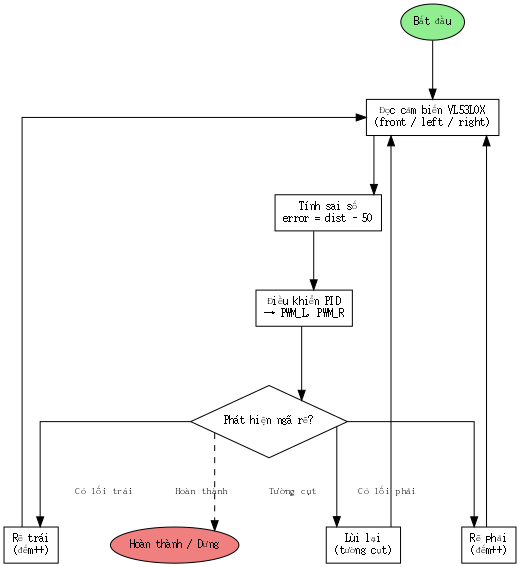

In [ ]:
# ================== CÀI FONT CHO TIẾNG VIỆT ==================
!apt-get install fonts-arphic-uming -y > /dev/null

# ================== VẼ SƠ ĐỒ KHỐI ==================
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(format='png')

# Cấu hình bố cục: hiển thị theo chiều dọc, cao hơn, không quá dài
dot.attr(rankdir='TB', size='4,6', dpi='130', splines='ortho', nodesep='0.5', ranksep='0.8')

# Gán font có hỗ trợ Unicode tiếng Việt
dot.attr('graph', fontname='AR PL UMing CN')
dot.attr('node', fontname='AR PL UMing CN', fontsize='11')
dot.attr('edge', fontname='AR PL UMing CN', fontsize='10')

# ===== Các khối =====
dot.node('Start', 'Bắt đầu', shape='ellipse', style='filled', fillcolor='lightgreen')
dot.node('Sensor', 'Đọc cảm biến VL53L0X\n(front / left / right)', shape='box')
dot.node('Error', 'Tính sai số\nerror = dist - 50', shape='box')
dot.node('PID', 'Điều khiển PID\n→ PWM_L, PWM_R', shape='box')
dot.node('Detect', 'Phát hiện ngã rẽ?', shape='diamond', width='1.2', height='1')

dot.node('Left', 'Rẽ trái\n(đếm++)', shape='box')
dot.node('Right', 'Rẽ phải\n(đếm++)', shape='box')
dot.node('Back', 'Lùi lại\n(tường cụt)', shape='box')
dot.node('End', 'Hoàn thành / Dừng', shape='ellipse', style='filled', fillcolor='lightcoral')

# ===== Liên kết =====
dot.edge('Start', 'Sensor')
dot.edge('Sensor', 'Error')
dot.edge('Error', 'PID')
dot.edge('PID', 'Detect')

dot.edge('Detect', 'Left', label='Có lối trái')
dot.edge('Detect', 'Right', label='Có lối phải')
dot.edge('Detect', 'Back', label='Tường cụt')
dot.edge('Detect', 'End', label='Hoàn thành', style='dashed')

dot.edge('Left', 'Sensor')
dot.edge('Right', 'Sensor')
dot.edge('Back', 'Sensor')

# Hiển thị ảnh trực tiếp
display(Image(dot.pipe(format='png')))
